In [6]:
import torch

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
from pathlib import Path
data_20_percent_path = Path("data/pizza_steak_sushi_20_percent/")
data_20_percent_path

WindowsPath('data/pizza_steak_sushi_20_percent')

In [9]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [10]:
# import torchvision

# from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url
# from torchvision import transforms

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# effnet_b2_weights = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)

# effnet_b2_transforms = effnet_b2_weights.transforms()
# effnet_b2 = efficientnet_b2(weights="DEFAULT").to(device)


In [6]:
def set_seeds():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

In [2]:
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNet-B2 feature extractor model and transforms."""
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    
    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return model, transforms

In [16]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

In [17]:
from torchinfo import summary
summary(effnetb2, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [18]:
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [19]:
len(train_dataloader), len(test_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [20]:
from going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9697 | train_acc: 0.5312 | test_loss: 0.7220 | test_acc: 0.9500
Epoch: 2 | train_loss: 0.7083 | train_acc: 0.8396 | test_loss: 0.5686 | test_acc: 0.9472
Epoch: 3 | train_loss: 0.5583 | train_acc: 0.8750 | test_loss: 0.4873 | test_acc: 0.9256
Epoch: 4 | train_loss: 0.5047 | train_acc: 0.8812 | test_loss: 0.4158 | test_acc: 0.9443
Epoch: 5 | train_loss: 0.4335 | train_acc: 0.8854 | test_loss: 0.3708 | test_acc: 0.9625
Epoch: 6 | train_loss: 0.4333 | train_acc: 0.8875 | test_loss: 0.3426 | test_acc: 0.9290
Epoch: 7 | train_loss: 0.3553 | train_acc: 0.9146 | test_loss: 0.3248 | test_acc: 0.9534
Epoch: 8 | train_loss: 0.3442 | train_acc: 0.8688 | test_loss: 0.3376 | test_acc: 0.9227
Epoch: 9 | train_loss: 0.4014 | train_acc: 0.8500 | test_loss: 0.2861 | test_acc: 0.9625
Epoch: 10 | train_loss: 0.3120 | train_acc: 0.8875 | test_loss: 0.2689 | test_acc: 0.9472


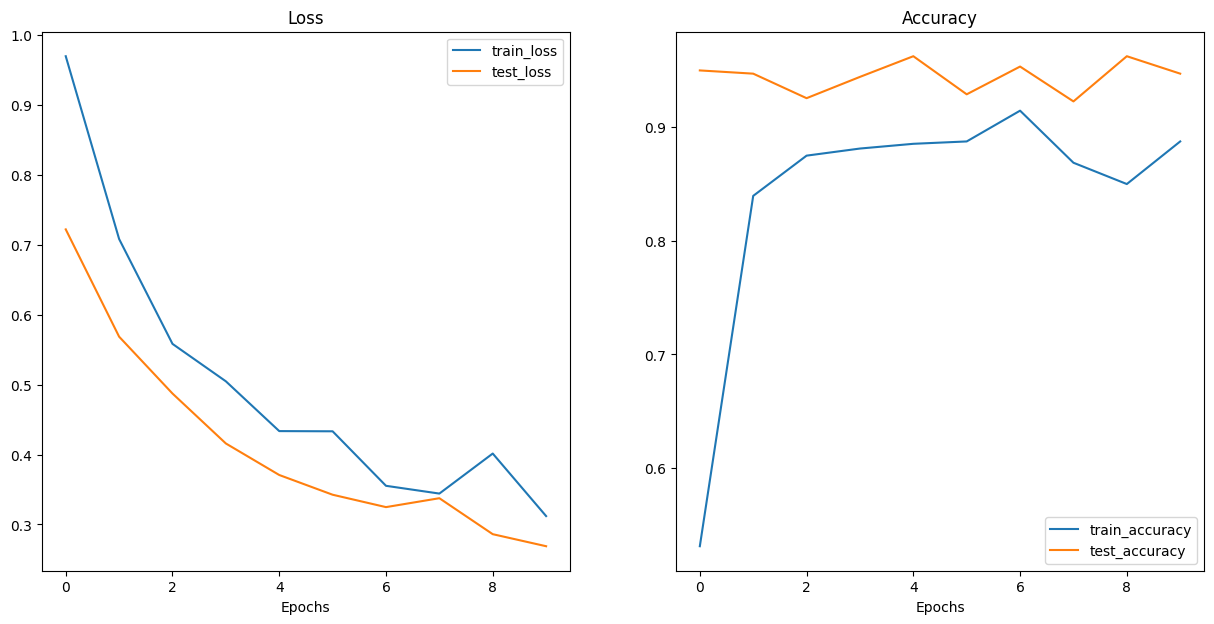

In [21]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [22]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [23]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / 1024 ** 2 # convert bytes to megabytes
print(f"Pretrained EffnetB2 model size: {pretrained_effnetb2_model_size:.2f} MB")

Pretrained EffnetB2 model size: 29.86 MB


In [24]:
# count number of parameters in EffNetB2

effnetb2_params = sum(p.numel() for p in effnetb2.parameters())
effnetb2_params

7705221

In [25]:
effnetb2_stats = {
    "test_loss": effnetb2_results["test_loss"][-1],
    "test_acc": effnetb2_results["test_acc"][-1],
    "number_of_parameters":effnetb2_params,
    "model_size": pretrained_effnetb2_model_size
}
effnetb2_stats

{'test_loss': 0.2689087241888046,
 'test_acc': 0.947159090909091,
 'number_of_parameters': 7705221,
 'model_size': 29.8638858795166}

In [26]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [27]:
def create_vit_model(num_classes:int = 3,
                     seed:int=42):
    """Creates a ViT feature extractor model and transforms."""
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False
    
    set_seeds()
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes, bias=True)
    )
    return model, transforms

In [28]:
vit, vit_transforms = create_vit_model(num_classes=3)
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [29]:
summary(vit, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:234.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [30]:
from going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [31]:
from going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)

set_seeds()
vit_results = engine.train(model=vit,
                            train_dataloader=train_dataloader_vit,
                            test_dataloader=test_dataloader_vit,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=10,
                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:234.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


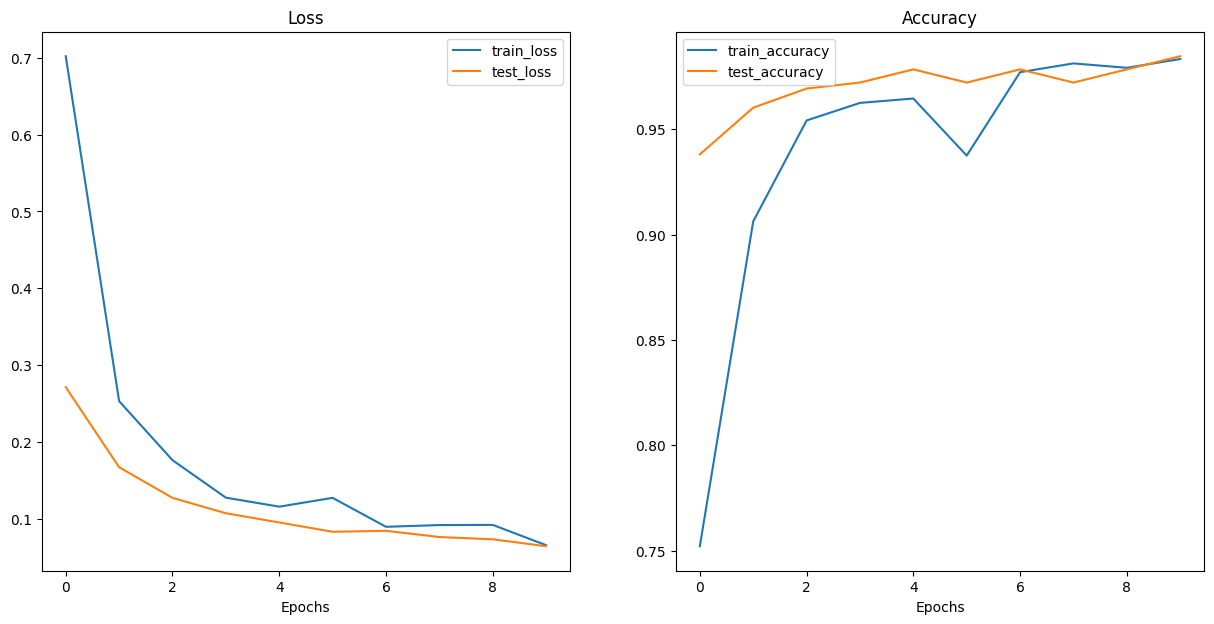

In [32]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [33]:
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [34]:
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / 1024 ** 2 # convert bytes to megabytes
print(f"Pretrain ViT Model Size: {pretrained_vit_model_size:.2f} MB")

Pretrain ViT Model Size: 327.37 MB


In [35]:
vit_total_params = sum(p.numel() for p in vit.parameters())
vit_total_params

85800963

In [36]:
vit_stats = {
    "test_loss": vit_results["test_loss"][-1],
    "test_acc": vit_results["test_acc"][-1],
    "number_of_parameters":vit_total_params,
    "model_size": pretrained_vit_model_size
}
vit_stats

{'test_loss': 0.06443451279774308,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size': 327.37096977233887}

In [37]:
from pathlib import Path

test_data_paths = list(test_dir.glob("*/*.jpg"))

test_data_paths[:5]

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

In [38]:
from typing import List, Dict
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm


def pred_and_store(paths:List[pathlib.Path], 
                   model:torch.nn.Module,
                   transform:torchvision.transforms, 
                   device:str = "cuda" if torch.cuda.is_available() else "cpu",
                   class_names:List[str] = None)->List[Dict]:
    """Make predictions on test dataset and store results in a list of dictionaries."""

    pred_list = []

    for path in tqdm(paths):
        img = Image.open(path)
        pred_dict = {}

        pred_dict["image_path"] = path 
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()
        img = Image.open(path)
        transformed_img = transform(img).unsqueeze(0).to(device)

        model = model.to(device=device)

        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_img)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)

    return pred_list


In [39]:
effnetb2_test_pred_dicts = pred_and_store(test_data_paths, effnetb2, effnetb2_transforms, class_names=class_names, device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [40]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9893,
  'pred_class': 'pizza',
  'time_for_pred': 0.3715,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5339,
  'pred_class': 'pizza',
  'time_for_pred': 0.1632,
  'correct': True}]

In [41]:
import pandas as pd 
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9893,pizza,0.3715,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.5339,pizza,0.1632,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9923,pizza,0.1651,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.6831,pizza,0.1713,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7630,pizza,0.1791,True


In [42]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     142
False      8
Name: count, dtype: int64

In [43]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"Average time per prediction: {effnetb2_average_time_per_pred}")

Average time per prediction: 0.1867


In [44]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2689087241888046,
 'test_acc': 0.947159090909091,
 'number_of_parameters': 7705221,
 'model_size': 29.8638858795166,
 'time_per_pred_cpu': 0.1867}

In [45]:
vit_test_pred_dicts = pred_and_store(test_data_paths, vit, vit_transforms, class_names=class_names, device="cpu")

vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()



  0%|          | 0/150 [00:00<?, ?it/s]

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.9818,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9957,pizza,0.8798,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.6805,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9869,pizza,0.6702,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9698,pizza,0.7212,True


In [46]:
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.9818,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9957,pizza,0.8798,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.6805,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9869,pizza,0.6702,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9698,pizza,0.7212,True


In [47]:
vit_test_pred_df.correct.value_counts()



correct
True     148
False      2
Name: count, dtype: int64

In [48]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"Average time per prediction: {vit_average_time_per_pred}")

Average time per prediction: 0.6159


In [49]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451279774308,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size': 327.37096977233887,
 'time_per_pred_cpu': 0.6159}

In [50]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffNetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size,time_per_pred_cpu,model
0,0.268909,94.72,7705221,29.863886,0.1867,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.6159,ViT


In [51]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), columns=["ViT to EffNetB2 Ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size,time_per_pred_cpu
ViT to EffNetB2 Ratios,0.239615,1.03959,11.135432,10.962102,3.298875


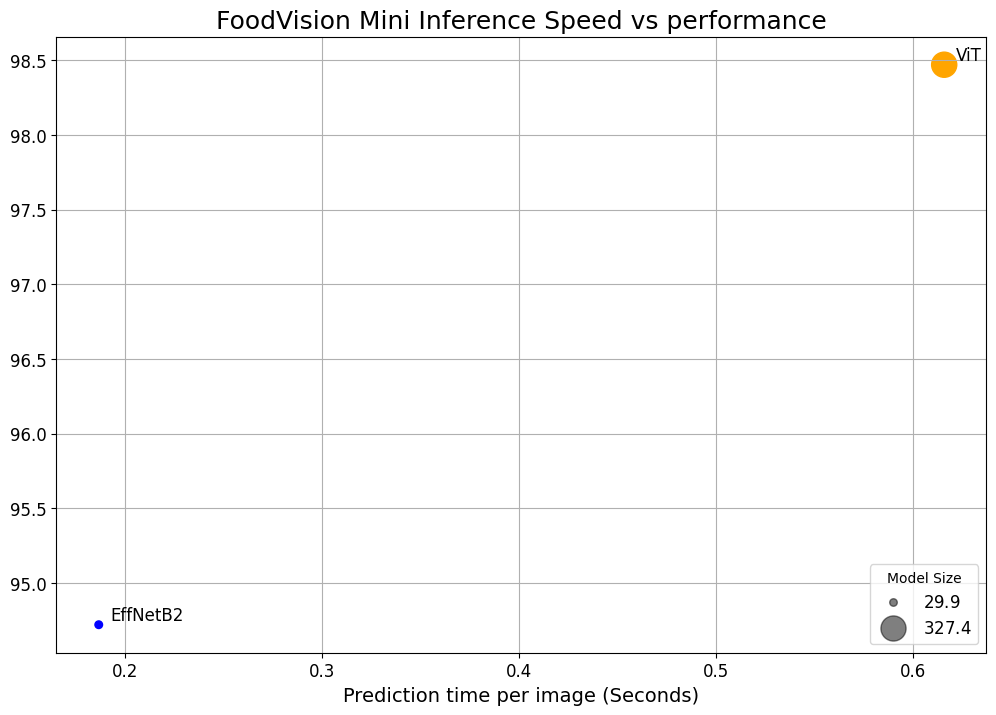

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue","orange"],
                     s="model_size")
ax.set_title("FoodVision Mini Inference Speed vs performance", fontsize=18)
ax.set_xlabel("Prediction time per image (Seconds)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.006, row["test_acc"]+0.03),
                size=12)
    
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, labels, title="Model Size", fontsize=12, loc="lower right")
plt.savefig("images/09_food_vision_mini_inference_speed_vs_performance.png")

In [53]:
!pip install gradio

DEPRECATION: Loading egg at c:\users\administrator\appdata\local\programs\python\python311\lib\site-packages\einops-0.7.0rc2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\administrator\appdata\local\programs\python\python311\lib\site-packages\progressbar-2.5-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\administrator\appdata\local\programs\python\python311\lib\site-packages\rotary_embedding_torch-0.3.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEP

In [54]:
effnetb2 = effnetb2.to("cpu")

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [55]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)


    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in  range(len(class_names))}

    end_timer = timer()
    pred_time = round(end_timer-start_time, 4)

    return pred_labels_and_probs, pred_time

In [56]:
import random 
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}")

pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\pizza\204151.jpg
{'pizza': 0.8996623158454895, 'steak': 0.03432106599211693, 'sushi': 0.06601662188768387}
0.1595


In [57]:
example_list = [[str(filepath)]for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\steak\\66858.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\592799.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\1523026.jpg']]

In [58]:
import gradio as gr
print(f"Gradio version: {gr.__version__}")

Gradio version: 3.50.2


In [63]:
import gradio as gr

title="FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor model that predicts pizza, steak and sushi"
article= "Created as a test"

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type="pil"), 
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), 
                             gr.Number(label="Prediction Time (s)")], 
                    examples=example_list, 
                    title=title, 
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)

Running on local URL:  http://127.0.0.1:7864
Running on public URL: https://23c0f8577a1c6b0bb2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [64]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini")

if foodvision_mini_demo_path.exists():
    shutil.rmtree(str(foodvision_mini_demo_path))

foodvision_mini_demo_path.mkdir(
    parents=True,
    exist_ok=True
)

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [68]:
import shutil 
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path/ "examples"

foodvision_mini_examples_path.mkdir(
    parents=True,
    exist_ok=True
)

foodvision_mini_examples = [
    Path('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
    Path('data/pizza_steak_sushi_20_percent/test/steak/367422.jpg'),
    Path('data/pizza_steak_sushi_20_percent/test/sushi/705150.jpg')
]

for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\648055.jpg to demos\foodvision_mini\examples\648055.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\367422.jpg to demos\foodvision_mini\examples\367422.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\705150.jpg to demos\foodvision_mini\examples\705150.jpg


In [70]:
import os 

example_list =[["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/367422.jpg'], ['examples/648055.jpg'], ['examples/705150.jpg']]

In [72]:
import shutil

effnetb2_foodvision_mini_model_path="models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path/effnetb2_foodvision_mini_model_path.split("/")[1]

try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    shutil.move(src=effnetb2_foodvision_mini_model_path, dst=effnetb2_foodvision_mini_model_destination)
    print(f"[INFO] Model Move Complete")
except:
    print(f"[INFO] Could not move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [84]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNet-B2 feature extractor model and transforms."""
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    
    torch.manual_seed(seed)

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return model, transforms

Overwriting demos/foodvision_mini/model.py


In [80]:
%%writefile demos/foodvision_mini/app.py

import gradio as gr
import os
import torch 
from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

class_names = ["pizza", "steak", "sushi"]
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

effnetb2.load_state_dict(torch.load("09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth", map_location=torch.device("cpu")))

def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)


    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in  range(len(class_names))}

    end_timer = timer()
    pred_time = round(end_timer-start_time, 4)

    return pred_labels_and_probs, pred_time

example_list =[["examples/" + example] for example in os.listdir("examples")]

import gradio as gr

title="FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor model that predicts pizza, steak and sushi"
article= "Created as a test"

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type="pil"), 
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), 
                             gr.Number(label="Prediction Time (s)")], 
                    examples=example_list, 
                    title=title, 
                    description=description,
                    article=article)

demo.launch(debug=False, share=False)



Overwriting demos/foodvision_mini/app.py


In [81]:
%%writefile demos/foodvision_mini/requirements.txt

torch
torchvision
gradio

Overwriting demos/foodvision_mini/requirements.txt


In [82]:
from IPython.display import IFrame

IFrame(src="https://huggingface.co/spaces/SafaAsgar/FoodVision_mini", width="100%", height="500")

In [85]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101, seed=42)

In [86]:
summary(effnetb2_food101, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [87]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [20]:
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [21]:
from torchvision import datasets

from pathlib import Path
data_dir = Path("data")

train_data = datasets.Food101(
    root=data_dir,
    split="train",
    transform=food101_train_transforms,
    download=True
)

test_data = datasets.Food101(
    root=data_dir,
    split="test",
    transform=effnetb2_transforms,
    download=True
)


In [22]:
food101_class_names = train_data.classes

food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [92]:
from torch.utils.data import random_split


def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
    length_1 = int(len(dataset)*split_size)
    length_2 = len(dataset) - length_1

    print(f"[INFO] Splitting dataset into {length_1} and {length_2}...")

    random_split_1, random_split_2 = random_split(dataset, [length_1, length_2], generator=torch.manual_seed(seed))

    return random_split_1, random_split_2

In [93]:
train_data_food101_20_percent, _ = split_dataset(dataset=train_data, split_size=0.2)

test_data_food101_20_percent, _ = split_dataset(dataset=test_data, split_size=0.2)

[INFO] Splitting dataset into 15150 and 60600...
[INFO] Splitting dataset into 5050 and 20200...


In [94]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

In [95]:
import torch 

BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    train_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    test_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)


In [96]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

In [97]:
from going_modular import engine 

optimizer = torch.optim.Adam(effnetb2_food101.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6404 | train_acc: 0.2790 | test_loss: 2.7884 | test_acc: 0.4913
Epoch: 2 | train_loss: 2.8610 | train_acc: 0.4445 | test_loss: 2.4756 | test_acc: 0.5351
Epoch: 3 | train_loss: 2.6611 | train_acc: 0.4832 | test_loss: 2.3546 | test_acc: 0.5576
Epoch: 4 | train_loss: 2.5488 | train_acc: 0.5086 | test_loss: 2.3051 | test_acc: 0.5742
Epoch: 5 | train_loss: 2.4890 | train_acc: 0.5244 | test_loss: 2.2739 | test_acc: 0.5751


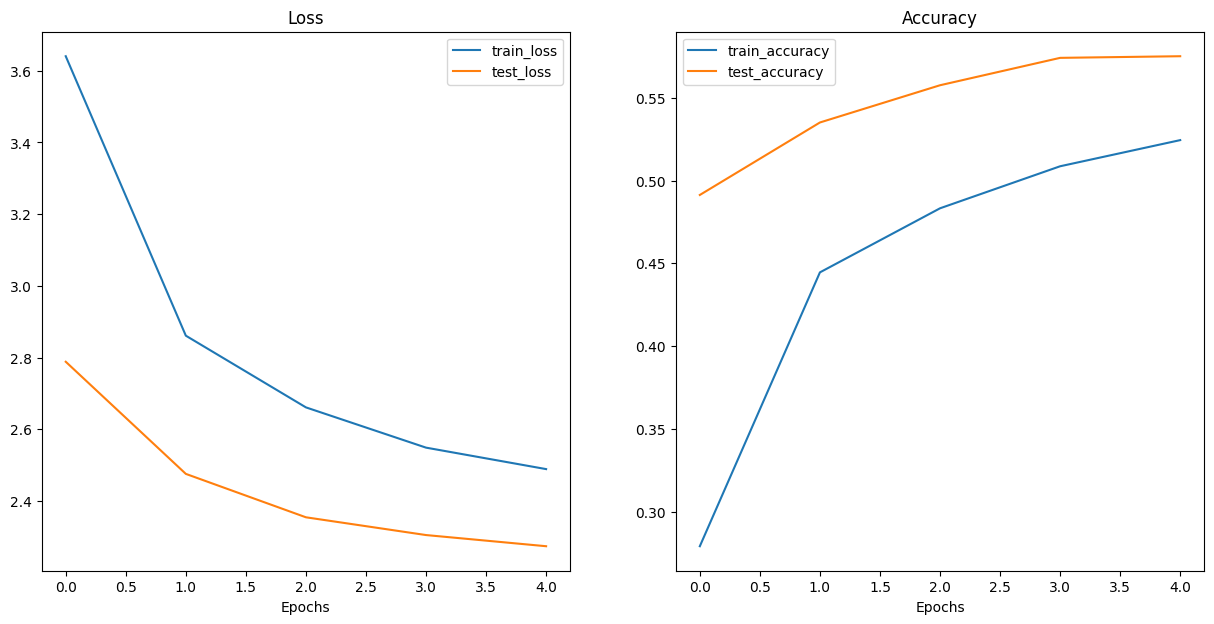

In [98]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

In [10]:
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

In [99]:
from going_modular import utils

utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [7]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

In [11]:
from pathlib import Path

pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size / 1000000   # convert bytes to megabytes
print(f"The pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_food101_model_size} MB")

The pretrained EffNetB2 feature extractor model size: 31.85721 MB


In [12]:
from pathlib import Path

foodvision_big_demo_path = Path("demos/foodvision_big")

foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

(foodvision_big_demo_path/"examples").mkdir(parents=True, exist_ok=True)

In [13]:
import shutil

shutil.copy2(src="data/04-pizza-dad.jpeg", dst="demos/foodvision_big/examples/")

'demos/foodvision_big/examples/04-pizza-dad.jpeg'

In [14]:
shutil.move(src="models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth", dst="demos/foodvision_big")

'demos/foodvision_big\\09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth'

In [15]:
foodvision_big_class_names_path = foodvision_big_demo_path/"class_names.txt"
foodvision_big_class_names_path

WindowsPath('demos/foodvision_big/class_names.txt')

In [23]:
with open(foodvision_big_class_names_path, "w") as f:
    print("[INFO] Writing class names to file...")
    f.write("\n".join(food101_class_names))

[INFO] Writing class names to file...


In [24]:
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = f.read().splitlines()
food101_class_names_loaded

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [25]:
%%writefile demos/foodvision_big/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNet-B2 feature extractor model and transforms."""
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    
    torch.manual_seed(seed)

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return model, transforms

Writing demos/foodvision_big/model.py


In [26]:
%%writefile demos/foodvision_big/app.py

import gradio as gr 
import os
import torch 
import torchvision

from model impor create_effnetb2_model
from timeit import default_timer as timer 
from typing import Tuple, Dict

with open("class_names.txt", " r") as f:
    class_names = f.read().splitlines()

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

effnetb2.load_state_dict(torch.load("09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth", map_location=torch.device("cpu")))


def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)


    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in  range(len(class_names))}

    end_timer = timer()
    pred_time = round(end_timer-start_time, 4)

    return pred_labels_and_probs, pred_time


import gradio as gr

example_list = [
    ["examples/" + example] for example in os.listdir("examples")
]

title="FoodVision Big 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor model that predicts pizza, steak and sushi"
article= "Trained with 20 Percent of Data from FoodVision Mini"

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type="pil"), 
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), 
                             gr.Number(label="Prediction Time (s)")], 
                    examples=example_list, 
                    title=title, 
                    description=description,
                    article=article)

demo.launch(debug=False, share=False)

Writing demos/foodvision_big/app.py


In [27]:
%%writefile demos/foodvision_big/requirements.txt

torch
torchvision
gradio

Writing demos/foodvision_big/requirements.txt
